## Drifters and Cmems data Notebook

### Introduction
This notebook aims to add the Ekman current components to the geostrophic components. Then, it extracts the inertial current components from drifter data using the nonlinear median and linear Hanning filter at a 24-hour resolution.


### Data Sources
- Drifter Data:
  - Source: NOAA
  - Data Product: Global Drifter Program Current of NOAA
  - Collection Frequency: Every 6 hours
  - Total Number of Drifters: 230
  - link : https://erddap.aoml.noaa.gov/gdp/erddap/tabledap/drifter_6hour_qc.html
  - period : 01-01-2022 to 01-01-2023

- CMEMS Data:
  - Source: Copernicus Marine, Satellite L4, Temporal resolution: Every 24 hours, Spatial resolution: 0.25°*0.25°
  - Data Product:  SEALEVEL_GLO_PHY_L4_MY_008_047 and MULTIOBS_GLO_PHY_MYNRT_015_003
  - link : https://doi.org/10.48670/moi-00148 and https://doi.org/10.48670/mds-00327
  - download data : ahttps://data.marine.copernicus.eu/product/SEALEVEL_GLO_PHY_L4_MY_008_047/download and https://data.marine.copernicus.eu/product/MULTIOBS_GLO_PHY_MYNRT_015_003/download
  - period : 01-01-2022 to 01-01-2023
  - DUACS  is the operationnal multimission production system of altimeter data developed by CNES/CLS. It features multimission products based on all altimetry satellites from GEOSAT to Jason-3 for a total of 100 years of cumulated data.

### Tasks

#### 1. Interpolation CMEMS data

 - Interpolation of geostrophic and Ekman components (DUACS current) over the spatial and temporal grid of the drifter.

#### 2. Total CMEMS currents
 - Adding the surface Ekman current to the geostrophic current.
 -  Using the nonlinear median and linear Hanning filter at a 24-hour resolution to extract the inertial current components.
 -  conclusion

#### 1. Interpolation CMEMS data

## Import Library

In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import utils as ut
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.interpolate import interp2d

from scipy.signal import medfilt
from scipy.signal import hann, convolve

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature
from cartopy import config
from scipy.stats import linregress
from scipy.stats import pearsonr

## Read Drifter Data

In [2]:
fn='./drifter_6hour_qc_a65f_894f_fcdf_U1719475759871.nc';
ds=xr.open_dataset(fn);

C:\ProgramData\anaconda3\Lib\site-packages\xarray\coding\times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
C:\ProgramData\anaconda3\Lib\site-packages\xarray\coding\times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


## Extract Coordinates and Variables

In [3]:
ve_curr = ds.ve.values
vn_curr = ds.vn.values
sst = ds.sst.values
lon = ds.longitude.values
lat = ds.latitude.values
time = ds.time.values

## Creation of Pandas Array for Drifter Data

In [4]:
data = {
    'longitude': lon,
    'latitude' : lat,
    'time'     : time,
    've'       : ve_curr,
    'vn'       : vn_curr,
    'sst'      : sst
}

df = pd.DataFrame(data)

## Now let's interpolate the CMEMS data onto the grid of the drifter data.

### Case of Geostrophic Velocity ugosa and  vgosa

In [5]:
# Loading drifting buoy data from the DataFrame
df_bouees = df
 
# Loading satellite data from the netCDF file
ds_satellitaires = xr.open_dataset('cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_1719675910724.nc') 
 
# Extracting satellite current data for the same spatial and temporal positions as the buoys
latitudes = df_bouees['latitude']
longitudes = df_bouees['longitude']
temps = df_bouees['time']

satellitaires_courant_u = []
for i in range(len(df_bouees)):
    lat = latitudes[i]
    lon = longitudes[i]
    time = temps[i]
    courant = ds_satellitaires['ugosa'].interp(latitude=lat, longitude=lon, time=time).values
    satellitaires_courant_u.append(courant)

satellitaires_courant_v = []
for i in range(len(df_bouees)):
    lat = latitudes[i]
    lon = longitudes[i]
    time = temps[i]
    courant = ds_satellitaires['vgosa'].interp(latitude=lat, longitude=lon, time=time).values
    satellitaires_courant_v.append(courant)

### Case of zonal and meridional ekman Component of 15m deep  current (ue) and (ve)

In [6]:
# Loading drifting buoy data from the DataFrame
df_bouees = df
 
# Loading satellite wind data from the netCDF file
ds_ek = xr.open_dataset('cmems_obs_mob_glo_phy-cur_my_0.25deg_P1D-m_1719676287157.nc')   
 
# Extracting satellite wind data for the same spatial and temporal positions as the buoys
latitudes = df_bouees['latitude']
longitudes = df_bouees['longitude']
temps = df_bouees['time']

satellite_ue = []
for i in range(len(df_bouees)):
    lat = latitudes[i]
    lon = longitudes[i]
    time = temps[i]
    courant = ds_ek['ue'].interp(latitude=lat, longitude=lon, time=time).values
    satellite_ue.append(courant)

satellite_ve = []
for i in range(len(df_bouees)):
    lat = latitudes[i]
    lon = longitudes[i]
    time = temps[i]
    courant = ds_ek['ve'].interp(latitude=lat, longitude=lon, time=time).values
    satellite_ve.append(courant)

#### 2. Adding the surface Ekman current to the geostrophic current.
-  Adding the surface Ekman current to the geostrophic current (CMEMS current) and conclusion.

## ugeos plus Ekman zonal current

In [7]:
# u_total = u_geostro + u_e_sat
u_total = [a + b for a, b in zip(satellitaires_courant_u, satellite_ue)]

## vgeos plus Ekman meridional current

In [8]:
# u_total = v_geostro + v_e_sat
v_total = [a + b for a, b in zip(satellitaires_courant_v, satellite_ve)]

## Creation of Pandas Array for CMEMS total current Data

In [9]:
data = {
     
    'u_total'       : u_total,
    'v_total'       : v_total
     
}

dF = pd.DataFrame(data)
dF = dF.astype({'u_total': 'float64', 'v_total': 'float64'})

## Comparison between (ve and u_total) and (vn and v_total)

## Using Regression and Correlation

## case of ve and u_total

Corrélation de Pearson: 0.6208026848502496
Valeur de p (p-value): 0.0


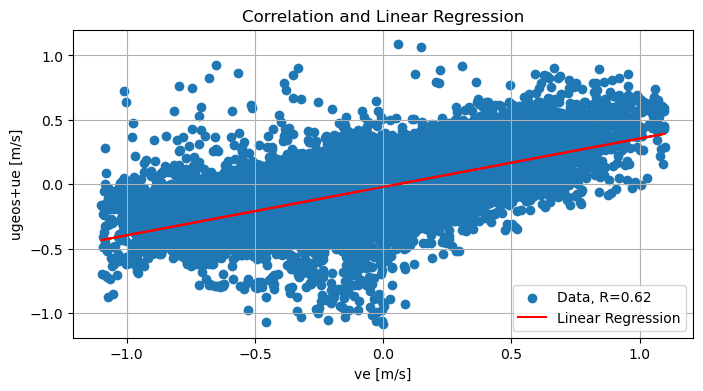

In [10]:
# According to the following, we can simply note that the correlation between "ve" and "ugeos + ue" is 0.62. 
# This means that there is a positive and moderate relationship  between this two variables.
# Calculation of spatial and temporal Pearson correlation

# Convert lists to NumPy arrays
bouees_courant_u = df['ve']
bouees_courant_u = np.array(bouees_courant_u)
satellitaires_courant_1 = np.array(dF['u_total'])

x = bouees_courant_u
y = satellitaires_courant_1
# Filtrer les valeurs strictement supérieures à 1.1 et inférieures à -1.1 dans x et y

valid_indice_1 = np.logical_and(np.logical_and(x <= 1.1, x >= -1.1), np.logical_and(y <= 1.1, y >= -1.1))
x_filtered = x[valid_indice_1]
y_filtered = y[valid_indice_1]

# Supprimer les lignes où y contient NaN et garder les correspondances dans x
valid_indice_2 = ~np.isnan(y_filtered)
x_clean = x_filtered[valid_indice_2]
y_clean = y_filtered[valid_indice_2]

# Calcul de la corrélation de Pearson
correlation, p_value = pearsonr(x_clean, y_clean)

print("Corrélation de Pearson:", correlation)
print("Valeur de p (p-value):", p_value)

# Fit linear regression model

slope, intercept, _, _, _ = linregress( x_clean,y_clean)

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(x_clean,y_clean, label=f'Data, R={correlation:.2f}')
plt.plot(x_clean, slope*x_clean + intercept, color='red', label='Linear Regression')
plt.xlabel('ve [m/s]')
plt.ylabel('ugeos+ue [m/s]')
plt.legend()
plt.title('Correlation and Linear Regression')
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'
plt.savefig("fig34 mode.png")
plt.show()

## case of vn and v_total

Corrélation de Pearson: 0.5104227447269596
Valeur de p (p-value): 0.0


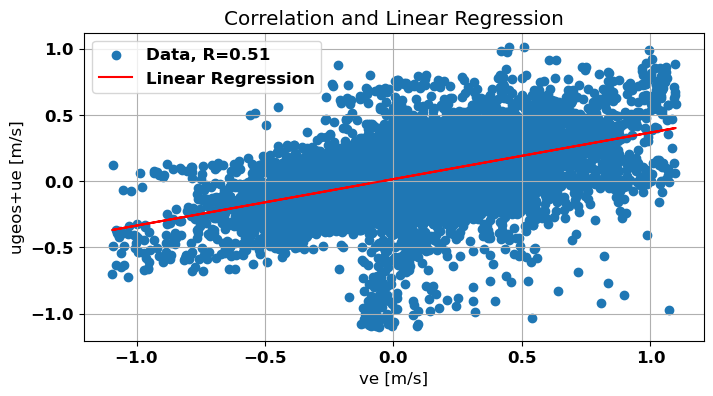

In [11]:
# According to the following, we can simply note that the correlation between "vn" and "vgeos + vn" is 0.51. 
# This means that there is a positive and moderate relationship  between this two variables.
# Calculation of spatial and temporal Pearson correlation

# Convert lists to NumPy arrays
bouees_courant_v = df['vn']
bouees_courant_v = np.array(bouees_courant_v)
satellitaires_courant_2 = np.array(dF['v_total'])

x = bouees_courant_v
y = satellitaires_courant_2
# Filtrer les valeurs strictement supérieures à 1.1 et inférieures à -1.1 dans x et y

valid_indice_3 = np.logical_and(np.logical_and(x <= 1.1, x >= -1.1), np.logical_and(y <= 1.1, y >= -1.1))
x_filtered = x[valid_indice_3]
y_filtered = y[valid_indice_3]

# Supprimer les lignes où y contient NaN et garder les correspondances dans x
valid_indice_4 = ~np.isnan(y_filtered)
x_clean_2 = x_filtered[valid_indice_4]
y_clean_2 = y_filtered[valid_indice_4]

# Calcul de la corrélation de Pearson
correlation, p_value = pearsonr(x_clean_2, y_clean_2)

print("Corrélation de Pearson:", correlation)
print("Valeur de p (p-value):", p_value)

# Fit linear regression model

slope, intercept, _, _, _ = linregress( x_clean_2,y_clean_2)

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(x_clean_2,y_clean_2, label=f'Data, R={correlation:.2f}')
plt.plot(x_clean_2, slope*x_clean_2 + intercept, color='red', label='Linear Regression')
plt.xlabel('ve [m/s]')
plt.ylabel('ugeos+ue [m/s]')
plt.legend()
plt.title('Correlation and Linear Regression')
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'
plt.savefig("fig35 mode.png")
plt.show()

## Application of a nonlinear median filter.

## Case of ve and vn

In [12]:
time = np.array(df['time'])   
current_data = np.array(df['ve'])   

# Apply a median filter with a window size of 3
ve_filter_med = medfilt(current_data, kernel_size=3)

In [13]:
time = np.array(df['time'])   
current_data = np.array(df['vn'])   

# Apply a median filter with a window size of 3
vn_filter_med = medfilt(current_data, kernel_size=3)

## Comparison between (ve_filter and u_total) and (vn_filter and v_total) 

## Using Regression and Correlation

## Case of ve_filter and u_total

Corrélation de Pearson: 0.6254055467156681
Valeur de p (p-value): 0.0


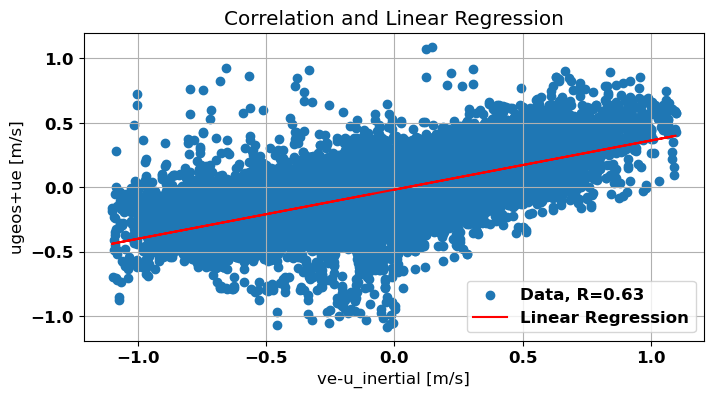

In [14]:
# According to the following, we can simply note that the correlation between "ve_filter_med" and "ugeos + ue" is 0.63. 
# This means that there is a positive and moderate relationship  between this two variables.
# Calculation of spatial and temporal Pearson correlation

# Convert lists to NumPy arrays
bouees_courant_uu = ve_filter_med
bouees_courant_uu = np.array(bouees_courant_uu)
satellitaires_courant_3 = np.array(dF['u_total'])

x = bouees_courant_uu
y = satellitaires_courant_3
# Filtrer les valeurs strictement supérieures à 1.1 et inférieures à -1.1 dans x et y

valid_indice_5 = np.logical_and(np.logical_and(x <= 1.1, x >= -1.1), np.logical_and(y <= 1.1, y >= -1.1))
x_filtered = x[valid_indice_5]
y_filtered = y[valid_indice_5]

# Supprimer les lignes où y contient NaN et garder les correspondances dans x
valid_indice_6 = ~np.isnan(y_filtered)
x_clean_3 = x_filtered[valid_indice_6]
y_clean_3 = y_filtered[valid_indice_6]

# Calcul de la corrélation de Pearson
correlation, p_value = pearsonr(x_clean_3, y_clean_3)

print("Corrélation de Pearson:", correlation)
print("Valeur de p (p-value):", p_value)

# Fit linear regression model

slope, intercept, _, _, _ = linregress( x_clean_3,y_clean_3)

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(x_clean_3,y_clean_3, label=f'Data, R={correlation:.2f}')
plt.plot(x_clean_3, slope*x_clean_3 + intercept, color='red', label='Linear Regression')
plt.xlabel('ve-u_inertial [m/s]')
plt.ylabel('ugeos+ue [m/s]')
plt.legend()
plt.title('Correlation and Linear Regression')
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'
plt.savefig("fig36 mode.png")
plt.show()

## Case of vn_filter and v_total

Corrélation de Pearson: 0.5182183256605404
Valeur de p (p-value): 0.0


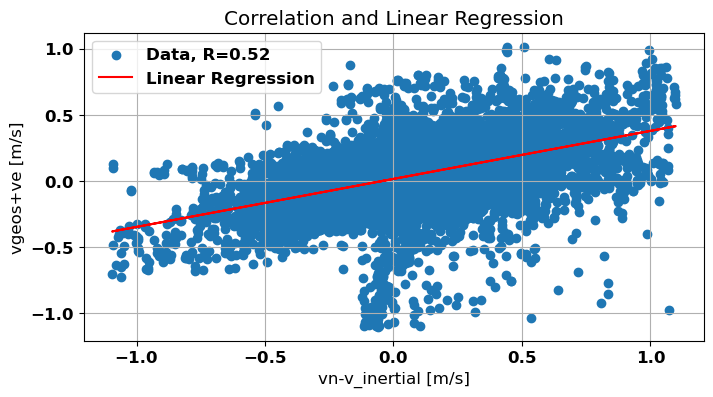

In [15]:
# According to the following, we can simply note that the correlation between "vn_filter_med" and "vgeos + ve" is 0.52. 
# This means that there is a positive and moderate relationship  between this two variables.
# Calculation of spatial and temporal Pearson correlation

# Convert lists to NumPy arrays
bouees_courant_vv = vn_filter_med
bouees_courant_vv = np.array(bouees_courant_vv)
satellitaires_courant_4 = np.array(dF['v_total'])

x = bouees_courant_vv
y = satellitaires_courant_4
# Filtrer les valeurs strictement supérieures à 1.1 et inférieures à -1.1 dans x et y

valid_indice_7 = np.logical_and(np.logical_and(x <= 1.1, x >= -1.1), np.logical_and(y <= 1.1, y >= -1.1))
x_filtered = x[valid_indice_7]
y_filtered = y[valid_indice_7]

# Supprimer les lignes où y contient NaN et garder les correspondances dans x
valid_indice_8 = ~np.isnan(y_filtered)
x_clean_4 = x_filtered[valid_indice_8]
y_clean_4 = y_filtered[valid_indice_8]

# Calcul de la corrélation de Pearson
correlation, p_value = pearsonr(x_clean_4, y_clean_4)

print("Corrélation de Pearson:", correlation)
print("Valeur de p (p-value):", p_value)

# Fit linear regression model

slope, intercept, _, _, _ = linregress( x_clean_4,y_clean_4)

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(x_clean_4,y_clean_4, label=f'Data, R={correlation:.2f}')
plt.plot(x_clean_4, slope*x_clean_4 + intercept, color='red', label='Linear Regression')
plt.xlabel('vn-v_inertial [m/s]')
plt.ylabel('vgeos+ve [m/s]')
plt.legend()
plt.title('Correlation and Linear Regression')
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'
plt.savefig("fig37 mode.png")
plt.show()

# Application of a linear Hanning filter

## Case of ve and vn

In [16]:
time = np.array(df['time'])   
current_data = np.array(df['ve'])   

# Parameters of the Hanning filter
window_length = 24  # Length of the Hanning window

# Applying the Hanning filter
window = hann(window_length)  # Create the Hanning window
ve_filter_Han = convolve(current_data, window, mode='same') / sum(window)  # Apply the Hanning filter

C:\Users\PC-M2OA\AppData\Local\Temp\ipykernel_18624\1989448933.py:8: DeprecationWarning: Importing hann from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hann' or the convenience function 'scipy.signal.get_window' instead.
  window = hann(window_length)  # Create the Hanning window


In [17]:
time = np.array(df['time'])   
current_data = np.array(df['vn'])   

# Parameters of the Hanning filter
window_length = 24  # Length of the Hanning window

# Applying the Hanning filter
window = hann(window_length)  # Create the Hanning window
vn_filter_Han = convolve(current_data, window, mode='same') / sum(window)  # Apply the Hanning filter

C:\Users\PC-M2OA\AppData\Local\Temp\ipykernel_18624\2735463738.py:8: DeprecationWarning: Importing hann from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hann' or the convenience function 'scipy.signal.get_window' instead.
  window = hann(window_length)  # Create the Hanning window


## New comparison between (ve_filter and u_total) and (vn_filter and v_total) 

## ve_filter_Han and u_total

Corrélation de Pearson: 0.6641253380587235
Valeur de p (p-value): 0.0


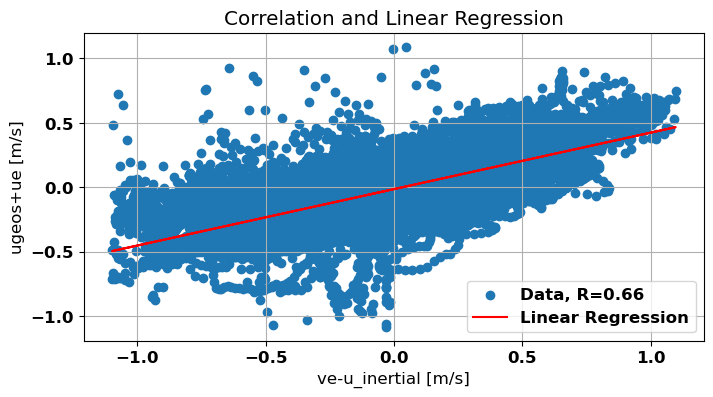

In [18]:
# According to the following, we can simply note that the correlation between "ve_filter_Han" and "ugeos + ue" is 0.66. 
# This means that there is a positive and moderate relationship  between this two variables.
# Calculation of spatial and temporal Pearson correlation

# Convert lists to NumPy arrays
bouees_courant_uuu = ve_filter_Han
bouees_courant_uuu = np.array(bouees_courant_uuu)
satellitaires_courant_4 = np.array(dF['u_total'])

x = bouees_courant_uuu
y = satellitaires_courant_4
# Filtrer les valeurs strictement supérieures à 0.5 et inférieures à -0.5 dans x et y

valid_indice_9 = np.logical_and(np.logical_and(x <= 1.1, x >= -1.1), np.logical_and(y <= 1.1, y >= -1.1))
x_filtered = x[valid_indice_9]
y_filtered = y[valid_indice_9]

# Supprimer les lignes où y contient NaN et garder les correspondances dans x
valid_indice_10 = ~np.isnan(y_filtered)
x_clean_5 = x_filtered[valid_indice_10]
y_clean_5 = y_filtered[valid_indice_10]

# Calcul de la corrélation de Pearson
correlation, p_value = pearsonr(x_clean_5, y_clean_5)

print("Corrélation de Pearson:", correlation)
print("Valeur de p (p-value):", p_value)

# Fit linear regression model

slope, intercept, _, _, _ = linregress( x_clean_5,y_clean_5)

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(x_clean_5,y_clean_5, label=f'Data, R={correlation:.2f}')
plt.plot(x_clean_5, slope*x_clean_5 + intercept, color='red', label='Linear Regression')
plt.xlabel('ve-u_inertial [m/s]')
plt.ylabel('ugeos+ue [m/s]')
plt.legend()
plt.title('Correlation and Linear Regression')
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'
plt.savefig("fig38 mode.png")
plt.show()

## vn_filter_Han and v_total

Corrélation de Pearson: 0.5981183962715111
Valeur de p (p-value): 0.0


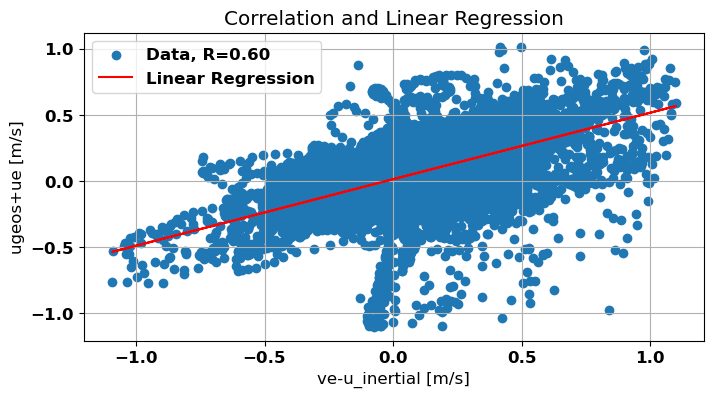

In [19]:
# According to the following, we can simply note that the correlation between "vn_filter_Han" and "vgeos + ve" is 0.60. 
# This means that there is a positive and moderate relationship  between this two variables.
# Calculation of spatial and temporal Pearson correlation

# Convert lists to NumPy arrays
bouees_courant_vvv = vn_filter_Han
bouees_courant_vvv = np.array(bouees_courant_vvv)
satellitaires_courant_5 = np.array(dF['v_total'])

x = bouees_courant_vvv
y = satellitaires_courant_5
# Filtrer les valeurs strictement supérieures à 0.5 et inférieures à -0.5 dans x et y

valid_indice_11 = np.logical_and(np.logical_and(x <= 1.1, x >= -1.1), np.logical_and(y <= 1.1, y >= -1.1))
x_filtered = x[valid_indice_11]
y_filtered = y[valid_indice_11]

# Supprimer les lignes où y contient NaN et garder les correspondances dans x
valid_indice_12 = ~np.isnan(y_filtered)
x_clean_6 = x_filtered[valid_indice_12]
y_clean_6 = y_filtered[valid_indice_12]

# Calcul de la corrélation de Pearson
correlation, p_value = pearsonr(x_clean_6, y_clean_6)

print("Corrélation de Pearson:", correlation)
print("Valeur de p (p-value):", p_value)

# Fit linear regression model

slope, intercept, _, _, _ = linregress( x_clean_6,y_clean_6)

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(x_clean_6,y_clean_6, label=f'Data, R={correlation:.2f}')
plt.plot(x_clean_6, slope*x_clean_6 + intercept, color='red', label='Linear Regression')
plt.xlabel('ve-u_inertial [m/s]')
plt.ylabel('ugeos+ue [m/s]')
plt.legend()
plt.title('Correlation and Linear Regression')
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'
plt.savefig("fig39 mode.png")
plt.show()

## Conclusion
-  Moderate correlation between drifter currents and altimetry currents (CMEMS Current).
-  Total meridional component dominated by the total altimetric zonal component.